# Experiment 2
Here a convolution layer is first used as before, but then two linear layers are used instead of another convolution layer

In [1]:
!ls ../datasets/swat/Physical/

ls: cannot access '../datasets/swat/Physical/': No such file or directory


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random
from torch.optim import Adam
import time
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import confusion_matrix, f1_score, roc_curve, roc_auc_score, precision_score, recall_score

In [3]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

### Dataset:

In [4]:
df = pd.read_csv('../../../Projects/data/SWaT_Dataset_Normal_v1.csv')
df.columns = df.columns.str.strip()
df = df.drop(columns=['Timestamp', 'Normal/Attack'])
grouping_array = np.arange(len(df)) // 5
df = df.groupby(grouping_array).median()
mm = MinMaxScaler()
Normalized = pd.DataFrame(mm.fit_transform(df))
train_set = Normalized[: int(0.8 * Normalized.shape[0])]
validation_set = Normalized[int(0.8 * Normalized.shape[0]):]

In [5]:
class SWat_dataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, target: pd.DataFrame,  window_size, device):
        self.data = dataframe
        self.window_size = window_size
        self.device = device

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        window = self.data[idx: idx + self.window_size]
        features = torch.tensor(window.iloc[:,:].values).float().to(self.device)
        return features

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Dataloader:

In [7]:
window_size = 30

train_dataset = SWat_dataset(train_set, train_set, window_size, device)
validation_dataset = SWat_dataset(validation_set, validation_set, window_size, device)

batch_size = 4096
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

### Model:

In [8]:
class GCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        
        self.dense = nn.Linear(in_dim, out_dim)

    def forward(self, adj, X):
        adj = adj + torch.eye(adj.size(0)).to(adj.device)
        h = self.dense(X)
        norm = adj.sum(1)**(-1/2)
        h = norm[None, :] * adj * norm[:, None] @ h
        return h
    
    
# A = ReLu(W)    
class Graph_ReLu_W(nn.Module):
    def __init__(self, num_nodes, k, device):
        super(Graph_ReLu_W, self).__init__()
        self.num_nodes = num_nodes
        self.k = k
        
        self.A = nn.Parameter(torch.randn(num_nodes, num_nodes).to(device), requires_grad=True).to(device)

    def forward(self, idx):
        
        adj = F.relu(self.A)
        
        if self.k:
            mask = torch.zeros(idx.size(0), idx.size(0)).to(self.device)
            mask.fill_(float('0'))
            s1,t1 = (adj + torch.rand_like(adj)*0.01).topk(self.k,1)
            mask.scatter_(1,t1,s1.fill_(1))
            adj = adj*mask
            
        return adj

# A for Directed graphs:
class Graph_Directed_A(nn.Module):
      
    def __init__(self, num_nodes, window_size, alpha, k, device):
        super(Graph_Directed_A, self).__init__()
        
        self.alpha = alpha
        self.k = k
        self.device = device
        
        self.e1 = nn.Embedding(num_nodes, window_size)
        self.e2 = nn.Embedding(num_nodes, window_size)
        self.l1 = nn.Linear(window_size,window_size)
        self.l2 = nn.Linear(window_size,window_size)
        
    def forward(self, idx):
        
        m1 = torch.tanh(self.alpha*self.l1(self.e1(idx)))
        m2 = torch.tanh(self.alpha*self.l2(self.e2(idx)))
        adj = F.relu(torch.tanh(self.alpha*torch.mm(m1, m2.transpose(1,0))))
        
        if self.k:
            mask = torch.zeros(idx.size(0), idx.size(0)).to(self.device)
            mask.fill_(float('0'))
            s1,t1 = (adj + torch.rand_like(adj)*0.01).topk(self.k,1)
            mask.scatter_(1,t1,s1.fill_(1))
            adj = adj*mask
        
        return adj

In [9]:
class GEncoder(nn.Module):
    def __init__(self, num_nodes, window_size, alpha, k, device):
        super(GEncoder, self).__init__()
        self.num_nodes = num_nodes
        self.window_size = window_size
        self.conv1 = GCNLayer(window_size, 20)
        self.conv2 = GCNLayer(20, 10)
        self.idx = torch.arange(num_nodes).to(device)
        self.A = Graph_Directed_A(num_nodes, window_size, alpha, k, device)
        self.device = device

    def forward(self, X):
        X = torch.transpose(X, 1, 2)
        adj = self.A(self.idx)
        h = self.conv1(adj, X).relu()
        h = self.conv2(adj, h).relu()
        return h
        
        

class GCN_autoencoder(nn.Module):
    def __init__(self, encoder, num_nodes, window_size):
        super(GCN_autoencoder, self).__init__()
        self.window_size = window_size
        self.num_nodes = num_nodes
        self.encoder = encoder
        self.decoder = nn.Sequential(
            nn.Linear(510, 1020),
            nn.ReLU(),
            nn.Linear(1020, num_nodes * window_size)
        )
        
    def forward(self, X):
        x = self.encoder(X)
        x = torch.flatten(x,1)
        x = self.decoder(x)
        return x.view(-1, self.window_size, self.num_nodes)

    def get_adj(self):
        return self.encoder.A(self.encoder.idx)

In [10]:
num_nodes = 51 # number of nodes
ngnn = 1 # number of graph structure learning layers
gsllayer = 'directed' # type of graph structure learning layer ('relu', 'directed', 'unidirected', 'undirected')
hidden_nodes = 12 # feature size in GCN layers
alpha = 0.2 # hyperparameter for weights of edges
k = None # max number of edges for each node
out_channels = 2 # number of process states

In [11]:
Encoder = GEncoder(num_nodes, window_size, alpha, k, device)
AE1 = GCN_autoencoder(Encoder, num_nodes, window_size)

In [12]:
AE1.to(device)

GCN_autoencoder(
  (encoder): GEncoder(
    (conv1): GCNLayer(
      (dense): Linear(in_features=30, out_features=20, bias=True)
    )
    (conv2): GCNLayer(
      (dense): Linear(in_features=20, out_features=10, bias=True)
    )
    (A): Graph_Directed_A(
      (e1): Embedding(51, 30)
      (e2): Embedding(51, 30)
      (l1): Linear(in_features=30, out_features=30, bias=True)
      (l2): Linear(in_features=30, out_features=30, bias=True)
    )
  )
  (decoder): Sequential(
    (0): Linear(in_features=510, out_features=1020, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1020, out_features=1530, bias=True)
  )
)

In [13]:
optimizer1 = torch.optim.Adam(AE1.parameters())

In [14]:
epochs = 50

In [15]:
%%time
AE1_val_history = []
for i in range(epochs):
    running_loss_AE1 = []
    val_loss_AE1 = []
    for index_b, features in enumerate(train_loader):
        
        w1 = AE1(features)
        lossAE1 = torch.mean((features - w1) ** 2)
        
        running_loss_AE1.append(lossAE1)
        lossAE1.backward()
        optimizer1.step()
        optimizer1.zero_grad()
    
    for index_b, features in enumerate(validation_loader):
        with torch.no_grad():

            w1 = AE1(features)
            lossAE1 = torch.mean((features - w1) ** 2)
            val_loss_AE1.append(lossAE1)
    AE1_val_history.append(torch.stack(val_loss_AE1).mean().item())
    # writer.add_scalar('Autoendoer_1_train_loss epoch', torch.stack(running_loss_AE1).mean().item(), i + 1)
    # writer.add_scalar('Autoendoer_1_train_loss epoch', AE1_val_history[-1], i + 1)
    print(f'Epoch: {i} ---> Val loss: AE1 {AE1_val_history[-1]:.4f}')
    print(f'Train loss: AE1 {torch.stack(running_loss_AE1).mean().item():.4f}')
    if round(torch.stack(running_loss_AE1).mean().item(), 4) > 0.012:
        continue
    if round(torch.stack(running_loss_AE1).mean().item(), 4) == round(AE1_val_history[-1], 4):
        break

Epoch: 0 ---> Val loss: AE1 0.0506
Train loss: AE1 0.1503
Epoch: 1 ---> Val loss: AE1 0.0305
Train loss: AE1 0.0431
Epoch: 2 ---> Val loss: AE1 0.0256
Train loss: AE1 0.0352
Epoch: 3 ---> Val loss: AE1 0.0141
Train loss: AE1 0.0265
Epoch: 4 ---> Val loss: AE1 0.0083
Train loss: AE1 0.0159
Epoch: 5 ---> Val loss: AE1 0.0058
Train loss: AE1 0.0090
Epoch: 6 ---> Val loss: AE1 0.0043
Train loss: AE1 0.0058
Epoch: 7 ---> Val loss: AE1 0.0035
Train loss: AE1 0.0043
Epoch: 8 ---> Val loss: AE1 0.0029
Train loss: AE1 0.0034
Epoch: 9 ---> Val loss: AE1 0.0025
Train loss: AE1 0.0028
Epoch: 10 ---> Val loss: AE1 0.0021
Train loss: AE1 0.0024
Epoch: 11 ---> Val loss: AE1 0.0019
Train loss: AE1 0.0021
Epoch: 12 ---> Val loss: AE1 0.0017
Train loss: AE1 0.0019
Epoch: 13 ---> Val loss: AE1 0.0016
Train loss: AE1 0.0018
Epoch: 14 ---> Val loss: AE1 0.0015
Train loss: AE1 0.0017
Epoch: 15 ---> Val loss: AE1 0.0014
Train loss: AE1 0.0016
Epoch: 16 ---> Val loss: AE1 0.0014
Train loss: AE1 0.0015
Epoch: 

# Testing

In [30]:
df2 = pd.read_csv('../../../Projects/data/SWaT_Dataset_Attack_v0.csv')
df2.columns = df2.columns.str.strip()
df2['attack'] = df2['Normal/Attack'].map({'Normal': 0, 'Attack': 1, 'A ttack': 1})
df2 = df2.drop(columns=['Timestamp', 'Normal/Attack'])
grouping_array = np.arange(len(df2)) // 5
df2 = df2.groupby(grouping_array).median()
labels = df2['attack']
df2 = df2.drop(columns=['attack'])

In [17]:
test_normalized = pd.DataFrame(mm.transform(df2))

In [18]:
test_dataset = SWat_dataset(test_normalized, test_normalized, window_size, device)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [19]:
def testing(test_loader, alpha=.5, beta=.5):
    results=[]
    with torch.no_grad():
        for batch in test_loader:
            w1=AE1(batch)
            results.append(torch.mean(torch.mean((batch-w1)**2, axis=1), axis=1))
    return results

In [20]:
windows_labels=[]
for i in range(len(labels)-window_size):
    windows_labels.append(list(np.int32(labels[i:i+window_size])))

In [21]:
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels]

In [22]:
results=testing(test_loader, alpha=0.3, beta=0.7)

In [23]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                       results[-1].flatten().detach().cpu().numpy()])

In [24]:
def ROC(y_test,y_pred):
    fpr,tpr,tr=roc_curve(y_test,y_pred)
    auc=roc_auc_score(y_test,y_pred)
    idx=np.argwhere(np.diff(np.sign(tpr-(1-fpr)))).flatten()

    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.plot(fpr,1-fpr,'r:')
    plt.plot(fpr[idx],tpr[idx], 'ro')
    plt.legend(loc=4)
    plt.grid()
    plt.show()
    return tr[idx]

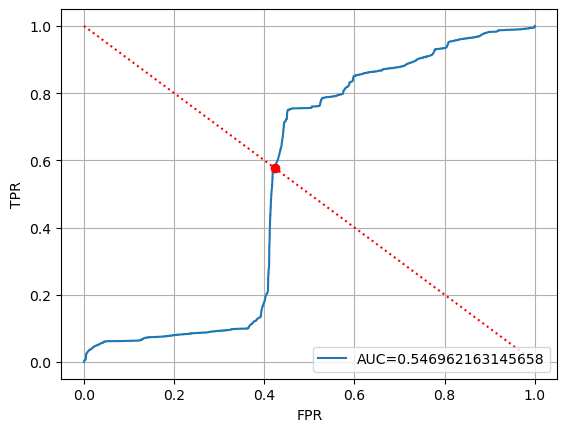

array([0.2819084], dtype=float32)

In [25]:
threshold = ROC(y_test,y_pred)
threshold

best: 0.24166666666666664 F1: 0.31765313574265713


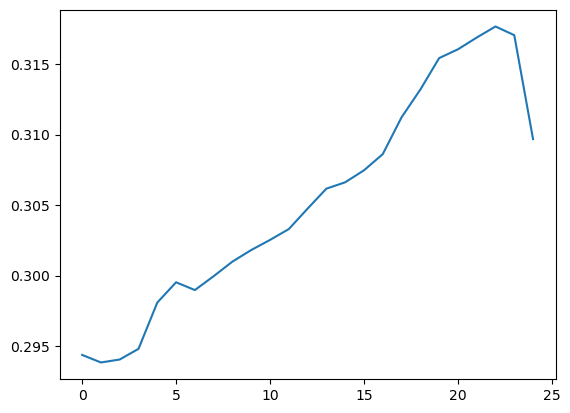

In [28]:
ff = 0
f_history = []
initial_y = 0.15
best = -1
for inc in np.linspace(0, 0.1, 25):
    y_pred_int = [1 if (yy > initial_y + inc) else 0 for yy in y_pred]
    conf_matrix = confusion_matrix(y_test, y_pred_int)
    TP = conf_matrix[1, 1]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    F1 = f1_score(y_test, y_pred_int)
    f_history.append(F1)

    precision = precision_score(y_test, y_pred_int)
    recall = recall_score(y_test, y_pred_int)
    if F1 > ff:
        ff = F1
        best = inc
print(f'best: {best + initial_y} F1: {ff}')
plt.plot(f_history)

In [30]:
metric_values = [77.6, 77.67,77.8, 78.4, 79.5, 78.35, 77.26]
np.mean(metric_values[1:-1])

78.34400000000001

In [32]:
df2 = pd.read_csv('../../../Projects/data/SWaT_Dataset_Attack_v0.csv')
df2.columns = df2.columns.str.strip()
df2['attack'] = df2['Normal/Attack'].map({'Normal': 0, 'Attack': 1, 'A ttack': 1})
labels = df2['attack']

In [36]:
started = False
anomaly_segments = []
for i in range(len(labels)):
    if labels[i] == 1 and not started:
        started = True
        left_side = i
    if labels[i] == 0 and started:
        started = False
        anomaly_segments.append((left_side, i - 1))

In [38]:
anomaly_segments

[(1754, 2693),
 (3068, 3510),
 (4920, 5302),
 (6459, 6848),
 (7255, 7450),
 (7705, 8133),
 (11410, 12373),
 (15380, 16100),
 (73800, 74520),
 (90685, 90917),
 (92140, 92570),
 (93445, 93720),
 (103092, 103808),
 (115843, 116101),
 (116143, 116537),
 (117000, 117720),
 (132918, 133380),
 (142954, 143650),
 (172268, 172588),
 (172910, 173521),
 (198296, 199740),
 (227828, 263727),
 (279120, 279240),
 (280060, 281230),
 (302653, 303019),
 (347679, 348279),
 (361191, 361634),
 (371479, 371579),
 (371855, 372335),
 (389680, 390219),
 (436541, 437009),
 (437417, 437697),
 (438147, 438547),
 (438621, 438917),
 (443501, 445190)]

In [39]:
for i, j in anomaly_segments:
    print(j - i)

939
442
382
389
195
428
963
720
720
232
430
275
716
258
394
720
462
696
320
611
1444
35899
120
1170
366
600
443
100
480
539
468
280
400
296
1689
